Importing the libraries to start the project
- torch for general imports
- torch.utils.data to the RandomSplit function
- torchvision.datasets to load the datasets from folders.
- torchvision.transforms.v2 to the Compose function and to apply the latest image transformations version
- numpy for any numerical calculation
- copy for deepcopy the torch arrays
- matplotlib.pyplot to visualize the images
- seaborn to visualize the distribution of the images

In [3]:
import torch
import torch.utils.data as data
from torchvision import datasets
from torchvision.transforms import v2
import numpy as np
import random
import copy
import matplotlib.pyplot as plt
import seaborn as sns

Insert the seed to guarantee that every run the result will be the same

In [4]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

labeling for the images

In [5]:
label_name = {
	0:'BK',
	1:'KFC',
	2:'McDonalds',
	3:'Other',
	4:'Starbucks',
	5:'Subway'
}

1. Here I apply the resize to 128x128 images, since I am running locally. I choose to not pick small images because they have a lot of noise from standard
2. Since the images already don't have any pattern as photo picture, I choose to not do any augmentation
3. Converting every array to an Image, i.e. interchangeable with pure Tensor 
4. Convert to Torch float 32 and scale
5. Normalize to the ImageNet patterns

In [6]:
IMG_SHAPE = (128, 128)

In [7]:
transform_train = v2.Compose([
	v2.Resize(IMG_SHAPE, antialias=True),
	v2.ToImage(),
	v2.ToDtype(torch.float32, scale=True),
	v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize the images
])

transform_test = v2.Compose([
	v2.Resize(IMG_SHAPE, antialias=True),
	v2.ToImage(),
	v2.ToDtype(torch.float32, scale=True),
	v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize the images
])

From the ImageFolder function we can easily import from folders inside folders that PyTorch will create each respective label

In [8]:
train_data, test_data = datasets.ImageFolder(root='logos3/train', transform=transform_train), datasets.ImageFolder(root='logos3/test', transform=transform_test)

Create a validation dataset to efectively train the data

In [9]:
VALID_RATIO = 0.89

n_train_examples = int(len(train_data) * VALID_RATIO)
n_valid_examples = len(train_data) - n_train_examples

Random split the train to train+validation

In [10]:
train_data, valid_data = data.random_split(train_data,
                                           [n_train_examples, n_valid_examples])

print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 1546
Number of validation examples: 192
Number of testing examples: 560


Deep copy the validation array of tensors and transform as the same transformations of the test data

In [11]:
valid_data = copy.deepcopy(valid_data)
valid_data.dataset.transform = transform_test

Iterables tensor in batch for memory optimization

In [12]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=False)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=64, shuffle=False)

In [13]:
def visualize_images(x_viz, y_viz, num_images=9):
    # Convert PyTorch tensors to NumPy arrays
    x_viz = x_viz.cpu().numpy()  # If using GPU, move tensors to CPU first
    y_viz = y_viz.cpu().numpy()

    for i in range(num_images):
        plt.subplot(3, 3, i + 1)
        plt.axis('off')
        
        # For grayscale images (1 channel)
        if x_viz.shape[1] == 1:
            plt.imshow(x_viz[i][0], cmap='gray')
        # For color images (3 channels: R, G, B)
        elif x_viz.shape[1] == 3:
            plt.imshow(np.transpose(x_viz[i], (1, 2, 0)))  # Change shape from (3, H, W) to (H, W, 3)
        
        plt.title(f'True Label: {label_name[y_viz[i]]}')

    plt.subplots_adjust(hspace=0.5)
    plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


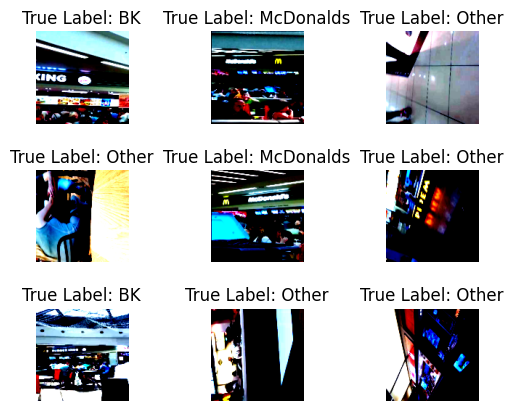

Batch 1: Batch Size - 64, Channels - 3, Height - 128, Width - 128


In [14]:
targets_full = []
for batch_idx, (inputs, targets) in enumerate(train_loader):
    visualize_images(inputs, targets)
    batch_size, num_channels, height, width = inputs.size()
    print(f'Batch {batch_idx + 1}: Batch Size - {batch_size}, Channels - {num_channels}, Height - {height}, Width - {width}')
    break  # Only visualize the first batch of data

for batch_idx, (inputs, targets) in enumerate(train_loader):
    
    targets_full.append(targets)
    
for batch_idx, (inputs, targets) in enumerate(valid_loader):
    targets_full.append(targets)


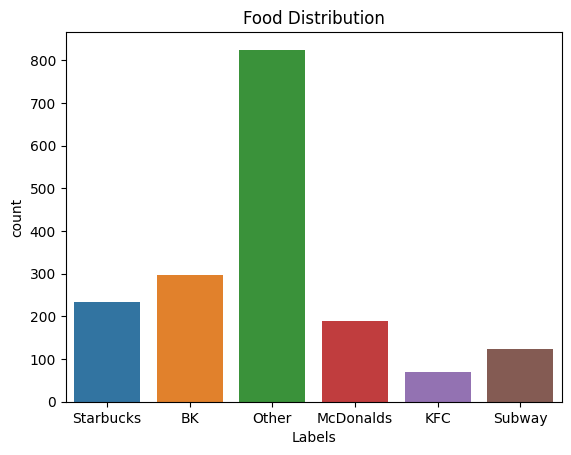

In [15]:
targets_full = np.concatenate([tensor.numpy() for tensor in targets_full])
targets_labels = [label_name[x] for x in targets_full]
sns.countplot(x=targets_labels);
plt.xlabel('Labels')
plt.title("Food Distribution");

In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data

import torchvision.transforms as transforms
import torchvision.datasets as datasets

from sklearn import metrics
from sklearn import decomposition
from sklearn import manifold
from tqdm.notebook import trange, tqdm
import matplotlib.pyplot as plt
import numpy as np

import copy
import random
import time

In [17]:
class MLP(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.input_fc = nn.Linear(input_dim, 250)
        self.hidden_fc = nn.Linear(250, 100)
        self.output_fc = nn.Linear(100, output_dim)

    def forward(self, x):
        batch_size = x.size(0)
        x = x.view(batch_size, -1)  # Flatten the input: 3x128x128 -> 49152
        h_1 = F.relu(self.input_fc(x))
        h_2 = F.relu(self.hidden_fc(h_1))
        y_pred = self.output_fc(h_2)
        return y_pred, h_2

In [18]:
#define dimensions of the model
INPUT_DIM = 3 * IMG_SHAPE[0] * IMG_SHAPE[1]
OUTPUT_DIM = 6

model = MLP(INPUT_DIM, OUTPUT_DIM)

In [19]:
# a function to count how many parameters in the mlp
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 12,313,956 trainable parameters


In [20]:
#defining the optmizer
optimizer = optim.Adam(model.parameters())
#defining loss function
criterion = nn.CrossEntropyLoss()
#setup GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
criterion = criterion.to(device)

In [21]:
# afunction to calculate validation accuracy
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim=True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

In [22]:
def train(model, iterator, optimizer, criterion, device):

    epoch_loss = 0
    epoch_acc = 0
    model.train()
    for (x, y) in tqdm(iterator, desc="Training", leave=False):

        x = x.to(device)
        y = y.to(device)
        optimizer.zero_grad()
        y_pred, _ = model(x)
        loss = criterion(y_pred, y)
        acc = calculate_accuracy(y_pred, y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [23]:
def evaluate(model, iterator, criterion, device):

    epoch_loss = 0
    epoch_acc = 0
    model.eval()
    with torch.no_grad():
        for (x, y) in tqdm(iterator, desc="Evaluating", leave=False):
            x = x.to(device)
            y = y.to(device)
            y_pred, _ = model(x)
            loss = criterion(y_pred, y)
            acc = calculate_accuracy(y_pred, y)
            epoch_loss += loss.item()
            epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [24]:
# function to compute time
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [25]:
#put everything together
EPOCHS = 10
best_valid_loss = float('inf')
train_losses, valid_losses = [], []
train_accs, valid_accs = [], []
for epoch in trange(EPOCHS):
    start_time = time.monotonic()
    train_loss, train_acc = train(model, train_loader, optimizer, criterion, device)
    valid_loss, valid_acc = evaluate(model, valid_loader, criterion, device)
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    valid_losses.append(valid_loss)
    valid_accs.append(valid_acc)
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut1-model.pt')
        if epoch>=5:
            print('----- Early stopped -----')
            break
    end_time = time.monotonic()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

  0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 0m 4s
	Train Loss: 2.060 | Train Acc: 51.88%
	 Val. Loss: 1.246 |  Val. Acc: 65.10%


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 0m 2s
	Train Loss: 0.686 | Train Acc: 81.41%
	 Val. Loss: 0.970 |  Val. Acc: 73.44%


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 03 | Epoch Time: 0m 2s
	Train Loss: 0.285 | Train Acc: 91.31%
	 Val. Loss: 0.815 |  Val. Acc: 71.35%


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 0m 3s
	Train Loss: 0.119 | Train Acc: 96.83%
	 Val. Loss: 0.791 |  Val. Acc: 77.08%


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 05 | Epoch Time: 0m 3s
	Train Loss: 0.099 | Train Acc: 97.50%
	 Val. Loss: 0.760 |  Val. Acc: 76.04%


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 0m 2s
	Train Loss: 0.031 | Train Acc: 99.25%
	 Val. Loss: 0.806 |  Val. Acc: 78.12%


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 07 | Epoch Time: 0m 3s
	Train Loss: 0.012 | Train Acc: 99.88%
	 Val. Loss: 0.767 |  Val. Acc: 75.52%


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

----- Early stopped -----


In [26]:
# load the model
model.load_state_dict(torch.load('tut1-model.pt'))
test_loss, test_acc = evaluate(model, test_loader, criterion, device)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Test Loss: 2.937 | Test Acc: 56.13%


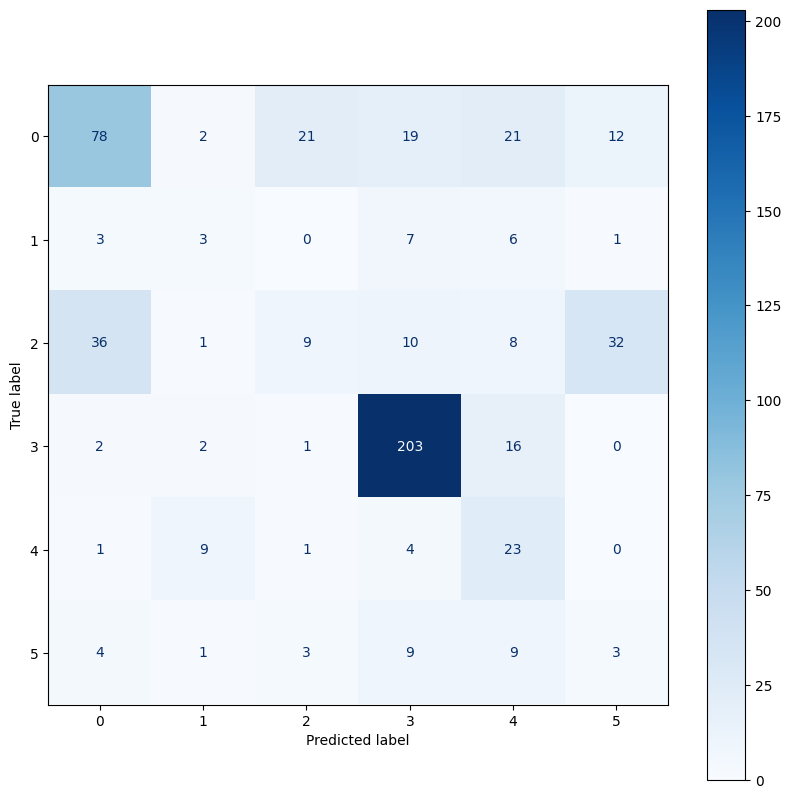

In [27]:
def get_predictions(model, iterator, device):

    model.eval()

    images = []
    labels = []
    probs = []

    with torch.no_grad():
        for (x, y) in iterator:
            x = x.to(device)
            y_pred, _ = model(x)
            y_prob = F.softmax(y_pred, dim=-1)
            images.append(x.cpu())
            labels.append(y.cpu())
            probs.append(y_prob.cpu())

    images = torch.cat(images, dim=0)
    labels = torch.cat(labels, dim=0)
    probs = torch.cat(probs, dim=0)

    return images, labels, probs

def plot_confusion_matrix(labels, pred_labels):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1)
    cm = metrics.confusion_matrix(labels, pred_labels)
    cm = metrics.ConfusionMatrixDisplay(cm, display_labels=range(6))
    cm.plot(values_format='d', cmap='Blues', ax=ax)



images, labels, probs = get_predictions(model, test_loader, device)
pred_labels = torch.argmax(probs, 1)
plot_confusion_matrix(labels, pred_labels)

In [28]:
def plot_metrics(train_metric, val_metric, metric_type):
  # Visualize metrics vs training Epochs
  plt.figure()
  plt.plot(range(len(train_metric)), train_metric, label = f"Training {metric_type}")
  plt.plot(range(len(val_metric)), val_metric, label = f"Validation {metric_type}")
  plt.xlabel("Epochs")
  plt.ylabel(metric_type)
  plt.legend()
  plt.title(f"{metric_type} vs Training epochs");

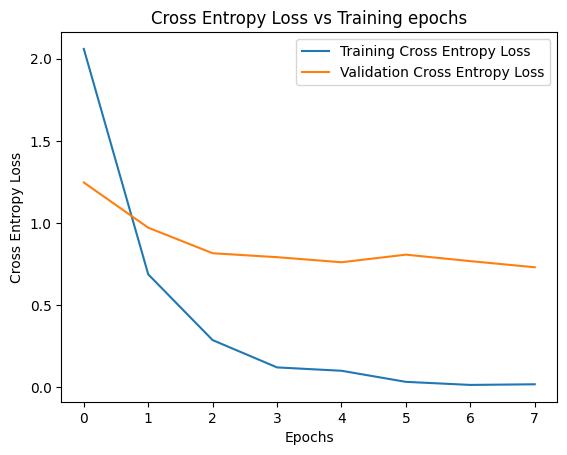

In [29]:
plot_metrics(train_losses, valid_losses, "Cross Entropy Loss")

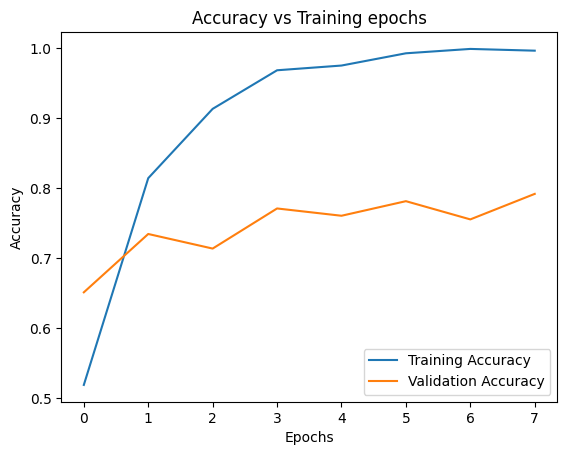

In [30]:
plot_metrics(train_accs, valid_accs, "Accuracy")

In [84]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import regularizers


# Define the CNN model using Keras
model = models.Sequential()

# Convolutional layers
model.add(layers.Conv2D(16, (3, 3), activation='relu', padding='same', input_shape=(128, 128, 3), kernel_regularizer=regularizers.l2(0.01)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01)))
model.add(layers.MaxPooling2D((2, 2)))

# Flatten the output and add fully connected layers
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5)) 
model.add(layers.Dense(6, activation='softmax'))  # 6 classes for classification

In [85]:
# # Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [86]:
# Print the model summary
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 128, 128, 16)      448       
                                                                 
 max_pooling2d_16 (MaxPooli  (None, 64, 64, 16)        0         
 ng2D)                                                           
                                                                 
 conv2d_17 (Conv2D)          (None, 64, 64, 32)        4640      
                                                                 
 max_pooling2d_17 (MaxPooli  (None, 32, 32, 32)        0         
 ng2D)                                                           
                                                                 
 flatten_8 (Flatten)         (None, 32768)             0         
                                                                 
 dense_25 (Dense)            (None, 128)             

In [87]:
# Define data generators for train and test data
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
test_datagen = ImageDataGenerator(rescale=1./255)

# Specify the paths to your train and test data directories
train_data_dir = 'logos3/train'
test_data_dir = 'logos3/test'

# Set batch size and image size
batch_size = 32
img_size = (128, 128)

# Create train and test data generators
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='sparse',  # for sparse categorical crossentropy loss
    shuffle=True
)

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='sparse',  # for sparse categorical crossentropy loss
    shuffle=False
)


# Train the model using fit_generator
num_epochs = 10
model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=num_epochs,
    validation_data=test_generator,
    validation_steps=test_generator.samples // batch_size
)


Found 1738 images belonging to 6 classes.
Found 560 images belonging to 6 classes.
Epoch 1/10
54/54 [==============================] - 5s 84ms/step - loss: 1.8009 - accuracy: 0.5129 - val_loss: 1.6522 - val_accuracy: 0.4835
Epoch 2/10
54/54 [==============================] - 4s 81ms/step - loss: 1.2074 - accuracy: 0.6284 - val_loss: 1.5592 - val_accuracy: 0.5147
Epoch 3/10
54/54 [==============================] - 5s 83ms/step - loss: 1.0213 - accuracy: 0.6864 - val_loss: 1.3665 - val_accuracy: 0.5331
Epoch 4/10
54/54 [==============================] - 5s 86ms/step - loss: 0.9295 - accuracy: 0.7263 - val_loss: 1.3390 - val_accuracy: 0.5533
Epoch 5/10
54/54 [==============================] - 5s 83ms/step - loss: 0.9416 - accuracy: 0.7292 - val_loss: 1.2045 - val_accuracy: 0.5974
Epoch 6/10
54/54 [==============================] - 4s 82ms/step - loss: 0.8918 - accuracy: 0.7427 - val_loss: 1.3403 - val_accuracy: 0.5588
Epoch 7/10
54/54 [==============================] - 4s 82ms/step - loss